# Metric Testing

Test different metrics (loss functions) on their relative effectiveness in evaluating the true model specification.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

In [3]:
from regime_switching.generate.arx import VARXGenerator

In [4]:
import statsmodels.api as sm

## Generate a specification

In [5]:
gen = VARXGenerator.random_model(
    n=2, m=0, p_max=2, 
    random_state=42
)

In [6]:
gen.endogenous.tolist(), gen.exogenous.tolist()

([0, 1], [])

In [7]:
y = gen.generate(100)

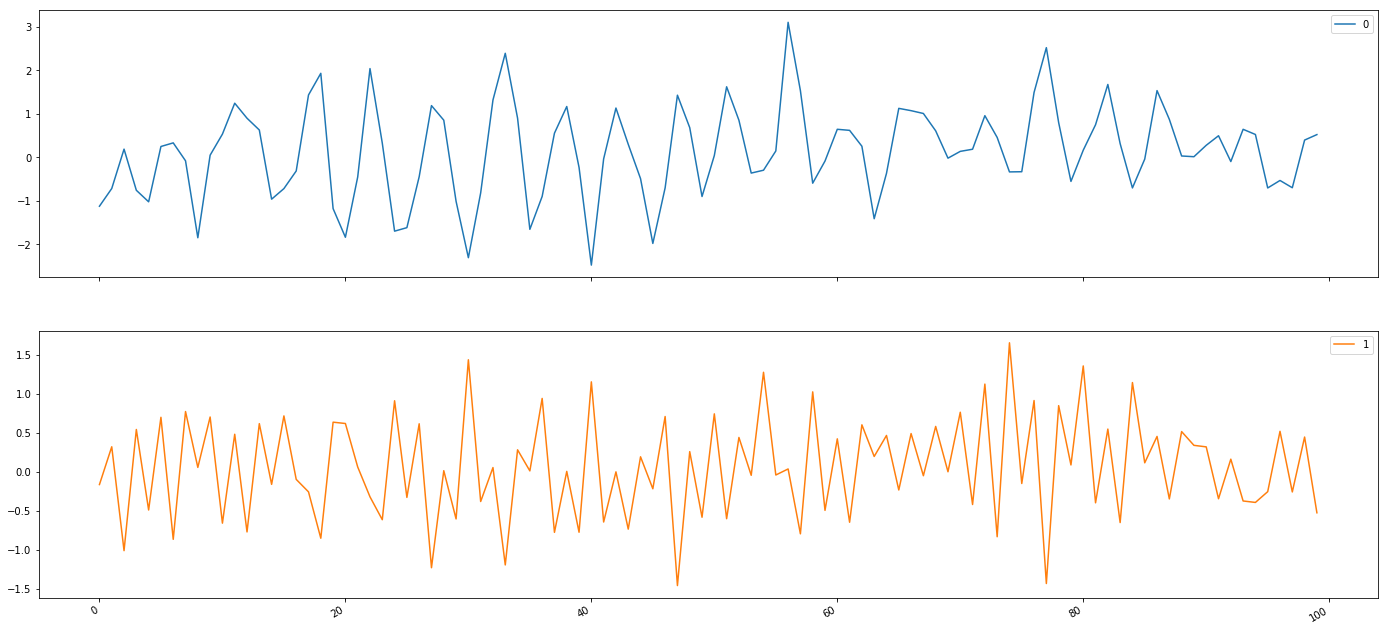

In [8]:
y.plot(subplots=True, figsize=(24, 12));

In [9]:
gen.coef_ar_df

0         1
lag                      
1   0  0.597991  0.397988
    1 -0.265972 -0.266008
2   0 -0.412875  0.799264
    1  0.401673  0.562109

In [10]:
gen.covariance

,0,1
0,0.593437,-0.129327
1,-0.129327,0.102225


In [11]:
gen.constants

0   -0.958831
1    0.939820
dtype: float64

In [12]:
for k in (gen.lags, gen.constants, gen.coef_ar_df, gen.coef_exog):
    display(k)

[1, 2]

0   -0.958831
1    0.939820
dtype: float64

0         1
lag                      
1   0  0.597991  0.397988
    1 -0.265972 -0.266008
2   0 -0.412875  0.799264
    1  0.401673  0.562109

,0,1


## Fit a model

We will use `statsmodels` to fit our models, because they incorporate the traditional statistical measures.

In [13]:
spec = sm.tsa.VAR(y, )

In [14]:
fitted = spec.fit(max(gen.lags))

In [15]:
fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, Apr, 2019
Time:                     16:57:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.18561
Nobs:                     98.0000    HQIC:                  -3.34269
Log likelihood:          -99.0923    FPE:                  0.0317709
AIC:                     -3.44938    Det(Omega_mle):       0.0287612
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.022360         0.069986            0.319           0.749
L1.0          0.619631         0.069547            8.910           0.000
L1.1          0.662675         0.139655            4.745           0.000
L2.0         -0.429070 

### Compare fitted values

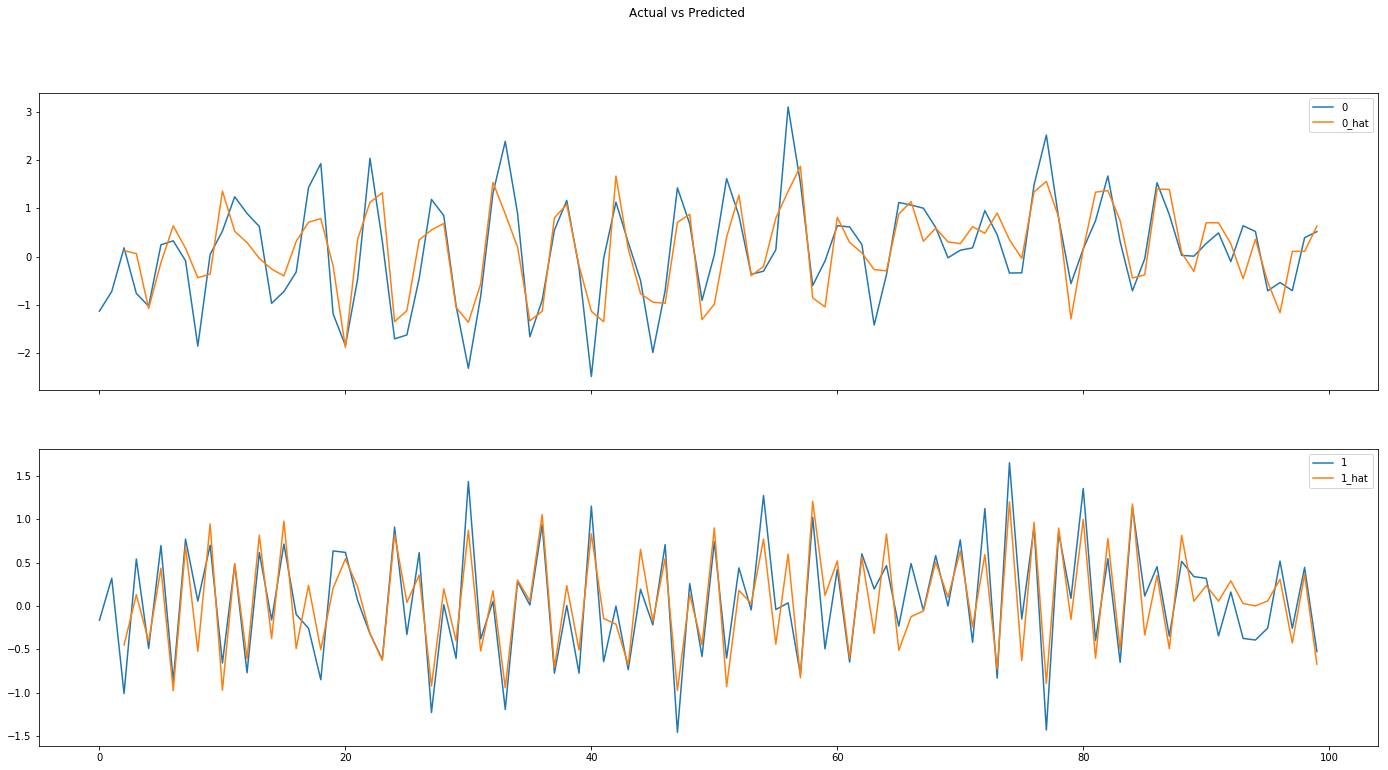

In [16]:
y_hat = fitted.fittedvalues

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
for i in range(2):
    y[[i]].plot(ax=ax[i]);
    (
        y_hat
        .rename(columns = {i: '{}_hat'.format(i) for i in range(2)})
        .iloc[:, i:i+1].plot(ax=ax[i])
    )
fig.suptitle("Actual vs Predicted")
fig;

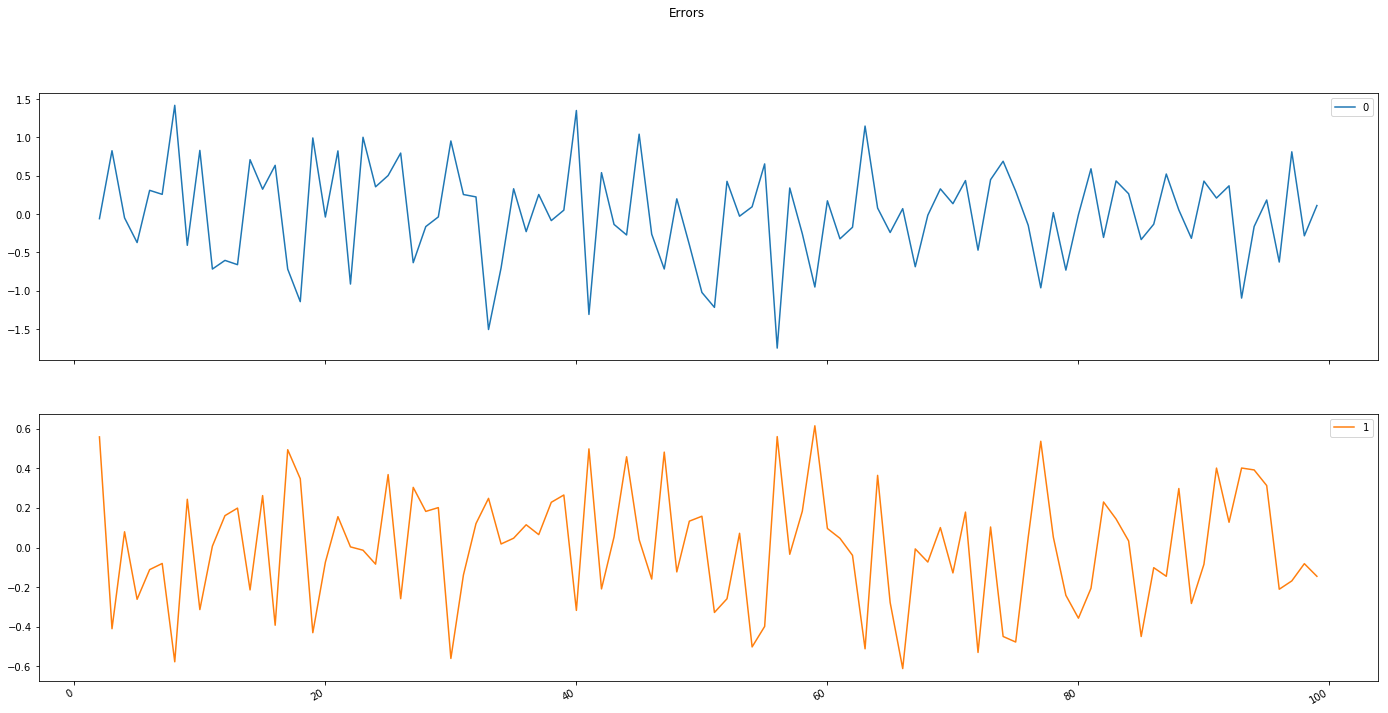

In [17]:
err = y_hat - y
err.plot(subplots=True, figsize=(24, 12))
plt.suptitle("Errors")
plt;

### Compare coefficients

In [18]:
fitted.coefs

array([[[ 0.61963067,  0.66267498],
        [-0.28492062, -0.28740187]],

       [[-0.42907035,  0.89750992],
        [ 0.44027015,  0.57387408]]])

In [19]:
hat_coef_ar_df = pd.DataFrame(
    fitted.coefs.reshape(-1, 2), 
    index=gen.coef_ar_df.index, 
    columns=gen.coef_ar_df.columns,
)
hat_coef_ar_df

0         1
lag                      
1   0  0.619631  0.662675
    1 -0.284921 -0.287402
2   0 -0.429070  0.897510
    1  0.440270  0.573874

In [20]:
fitted.coefs_exog

array([[0.02236047],
       [0.02722511]])

In [21]:
hat_coef_ar_df - gen.coef_ar_df

0         1
lag                      
1   0  0.021640  0.264687
    1 -0.018949 -0.021394
2   0 -0.016196  0.098246
    1  0.038598  0.011765

In [22]:
fitted.intercept

array([0.02236047, 0.02722511])

## Test Fit statespace-based VARX model

In [23]:
ssm = sm.tsa.VARMAX(y, order=(2, 0), trend='c', )
ssmr = ssm.fit(maxiter=200)

C:\Conda\envs\env-masters\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [24]:
ssmr.summary()

Dep. Variable:,"[0, 1]",No. Observations:,100
Model:,VAR(2),Log Likelihood,-102.872
,+ intercept,AIC,231.743
Date:,"Tue, 02 Apr 2019",BIC,265.611
Time:,16:57:10,HQIC,245.450
Sample:,0,,
,- 100,,
Covariance Type:,opg,,
Ljung-Box (Q):,"44.91, 37.76",Jarque-Bera (JB):,"1.49, 2.01"
Prob(Q):,"0.27, 0.57",Prob(JB):,"0.48, 0.37"
Heteroskedasticity (H):,"0.50, 1.54",Skew:,"0.30, 0.32"


In [25]:
ssmr.specification

{'error_cov_type': 'unstructured',
 'measurement_error': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'order': (2, 0),
 'k_ar': 2,
 'k_ma': 0,
 'trend': 'c',
 'k_trend': 1,
 'k_exog': 0}

In [26]:
ssmr.params

const.0         0.012888
const.1         0.016320
L1.0.0          0.621082
L1.1.0          0.670726
L2.0.0         -0.421220
L2.1.0          0.896703
L1.0.1         -0.280059
L1.1.1         -0.278390
L2.0.1          0.437015
L2.1.1          0.574187
sqrt.var.0      0.626035
sqrt.cov.0.1   -0.144404
sqrt.var.1      0.255479
dtype: float64

In [27]:
ssmr.zvalues

const.0          0.190508
const.1          0.507545
L1.0.0           9.734508
L1.1.0           4.562968
L2.0.0          -5.416303
L2.1.0           6.206126
L1.0.1          -7.913174
L1.1.1          -4.238840
L2.0.1          12.341256
L2.1.1           7.890343
sqrt.var.0      11.679905
sqrt.cov.0.1    -4.636657
sqrt.var.1      11.490153
dtype: float64

In [28]:
ss_coefs = pd.DataFrame(
    ssmr.coefficient_matrices_var.reshape(-1, 2), 
    index=gen.coef_ar_df.index, 
    columns=gen.coef_ar_df.columns,
)
ss_coefs

0         1
lag                      
1   0  0.621082  0.670726
    1 -0.280059 -0.278390
2   0 -0.421220  0.896703
    1  0.437015  0.574187

In [29]:
gen.coef_ar_df

0         1
lag                      
1   0  0.597991  0.397988
    1 -0.265972 -0.266008
2   0 -0.412875  0.799264
    1  0.401673  0.562109

In [30]:
# Much better :)
(ss_coefs - gen.coef_ar_df) / gen.coef_ar_df

0         1
lag                      
1   0  0.038614  0.685292
    1  0.052963  0.046548
2   0  0.020214  0.121911
    1  0.087989  0.021487

In [31]:
def fit_mdl(
    y, x=None, ar_order=0, trend='c', maxiter=200, 
):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ssm = sm.tsa.VARMAX(y, x, order=(ar_order, 0), trend=trend, )
        res = ssm.fit(maxiter=200)
    
    res.all_coeffs = pd.DataFrame({
        'coeff': res.params, 
        'z_stat': res.zvalues, 
        'p_value': res.pvalues,
    })
    
    return res
    

In [32]:
t1 = fit_mdl(y, ar_order=2)

In [33]:
t1

In [34]:
(
    pd.concat([
        gen.params.rename('actual'), 
        t1.all_coeffs
    ], axis='columns', sort=True)
    .style.format('{:.3f}')
)

,actual,coeff,z_stat,p_value
L1.0.0,0.598,0.621,9.735,0.000
L1.0.1,0.398,-0.280,-7.913,0.000
L1.1.0,-0.266,0.671,4.563,0.000
L1.1.1,-0.266,-0.278,-4.239,0.000
L2.0.0,-0.413,-0.421,-5.416,0.000
L2.0.1,0.799,0.437,12.341,0.000
L2.1.0,0.402,0.897,6.206,0.000
L2.1.1,0.562,0.574,7.890,0.000
const.0,-0.959,0.013,0.191,0.849
const.1,0.940,0.016,0.508,0.612


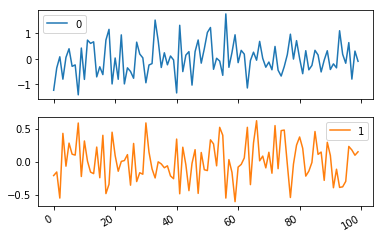

In [35]:
t1.resid.plot(subplots=True);

## Loss function definitions

In [46]:
t1.summary()

Dep. Variable:,"[0, 1]",No. Observations:,100
Model:,VAR(2),Log Likelihood,-102.872
,+ intercept,AIC,231.743
Date:,"Tue, 02 Apr 2019",BIC,265.611
Time:,17:16:39,HQIC,245.450
Sample:,0,,
,- 100,,
Covariance Type:,opg,,
Ljung-Box (Q):,"44.91, 37.76",Jarque-Bera (JB):,"1.49, 2.01"
Prob(Q):,"0.27, 0.57",Prob(JB):,"0.48, 0.37"
Heteroskedasticity (H):,"0.50, 1.54",Skew:,"0.30, 0.32"


In [ ]:
class LossCalculator(object):
    
    def __init__(self, fitted):
        # using 
        self.aic = fitted.aic
        self.bic = fitted.bic
        self.hqic = fitted.hqic
        self.log_likelihood = fitted.llf
        
        r = fitted.resid
        
        # TODO: 
        # check each individually
        # VAR serial correlation test
        # VAR heteroskedasticity LM test
        # joint JB test for VAR
        # portmanteau test for autocorrelation
        
        # determinant of covariance matrix of resids